## Glue deepnet to crcns data using the feature-weighted rf model

In [10]:
version_number =  '0p2'

In [11]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from time import time
from glob import glob
from scipy.io import loadmat
from PIL import Image
from scipy.stats import pearsonr
from src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu,bigmult
from src.feature_weighted_rf_models import train_fwrf_model
from src.gabor_feature_dictionaries import gabor_feature_maps
from os.path import join
from scipy.misc import imresize

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step (-1) : build crcns feature maps

#####load frame files and get keys we need

In [12]:
import utils

sub = 'MY'

df = utils.get_subject_for_analysis('/musc.repo/Data/nickdesisto/em9k_analysis/em9k.csv', sub)
frame_files = utils.frame_files(df)

keys_used_in_scans = frame_files.cond_map.values() ## 0 isnt an image
skeys_used_in_scans = map(lambda x : str(x).zfill(6),keys_used_in_scans)

subjects also available : ['CO' 'DM' 'MY' 'PHIL' 'TN']
DF loaded for subject MY with 43 runs
All 43 files have 10 lines per TR
1531 conditions found


#### load word2vec dictionary

In [13]:
import gensim

model = gensim.models.Word2Vec.load_word2vec_format('/mnt/GoogleNews-vectors-negative300.bin.gz',binary=True)

#### probably need these

In [14]:
betas_trn = pd.read_pickle('/musc.repo/Data/nickdesisto/em9k_analysis/beta_weight_data_frames/{}_trn_BetaFrame.df'.format(sub))
betas_val = pd.read_pickle('/musc.repo/Data/nickdesisto/em9k_analysis/beta_weight_data_frames/{}_val_BetaFrame.df'.format(sub))

#### create the picture blocks

In [15]:
def create_semantic_map(key,image_dir,resize=None):
    ''' resize is of form n -> (n,n) for resize shape'''
    from skimage.io import imread
    im_folder = str(key).zfill(6)
    fp = join(image_dir,im_folder)
    labels = open(join(fp,'{}.labels.txt'.format(im_folder)),'r').readlines()
    labels = [s.strip() for s in labels]
    im_map = imread(join(fp,'{}.png'.format(im_folder)))

    
    if len(labels) != len(np.unique(im_map)):
        print 'LABELS != NUMBER AT {}'.format(key)
        return np.zeros((300,resize,resize))
    
    if resize:    
        im_vals = np.unique(im_map)
        im_map = imresize(im_map,(resize,resize))
        im_vals_resize = np.unique(im_map)
        setdiff = np.setdiff1d(im_vals,im_vals_resize,assume_unique=True)
        for lost in setdiff:
            print 'img {} lost label {} : {} in resizing'.format(key,lost,labels[lost-1])
    else:
        resize = 500
            

    ret = np.zeros((resize,resize,300))
    for label_index in xrange(len(labels)):
        word_vec_vals = model[labels[label_index]]
        ret[im_map == label_index + 1] = word_vec_vals
    return np.swapaxes(ret,0,2)

In [18]:
dimsize = 50
maps = np.zeros((len(keys_used_in_scans),300,dimsize,dimsize))
for i,key in enumerate(keys_used_in_scans):
    if key != 0:
        try:
            maps[i] = create_semantic_map(key,'/mnt/my_labeled_images/image_folders/',resize=dimsize)
#             print '{} successfuly loaded'.format(key)
#             print '.',
        except IOError:
            print 'file {} no file'.format(key)
        except KeyError:
            print 'key error at {}'.format(key)

        
        

file 200000 no file
img 2884 lost label 12 : purse in resizing
img 1771 lost label 15 : wire in resizing
img 587 lost label 5 : signpost in resizing
img 587 lost label 6 : signpost in resizing
img 817 lost label 12 : window in resizing
img 502 lost label 15 : rope in resizing
img 19 lost label 12 : tap in resizing
img 19 lost label 13 : tap in resizing
img 2480 lost label 1 : light in resizing
img 3652 lost label 26 : silverware in resizing
img 2341 lost label 15 : human in resizing
img 2742 lost label 7 : ground in resizing
img 750 lost label 22 : bowl in resizing
img 1055 lost label 24 : bag in resizing
key error at 3926
img 2618 lost label 17 : bag in resizing
img 479 lost label 13 : truck in resizing
img 479 lost label 14 : tree in resizing
img 479 lost label 15 : steel in resizing
LABELS != NUMBER AT 3089
img 741 lost label 23 : paper in resizing
img 2042 lost label 5 : steamboat in resizing
LABELS != NUMBER AT 3062
img 2675 lost label 10 : spectator in resizing
LABELS != NUMBER A

In [19]:
print maps.shape
print np.count_nonzero(maps)
print np.prod(maps.shape)
print '% not zero : {}'.format(float(np.count_nonzero(maps))/np.prod(maps.shape))

(1531, 300, 50, 50)
1120500000
1148250000
% not zero : 0.975832789027


### Step 0: Load crcns feature maps

In [20]:
df_trn = df[df.runType=='trn']
df_val = df[df.runType=='val']

frame_files_trn = utils.frame_files(df_trn)
frame_files_val = utils.frame_files(df_val)
frame_files_all = utils.frame_files(df)

# print 'cond map'
# for key,val in list(frame_files_trn.cond_map.iteritems())[:3]:
#     print key,val
    
cond_inv = {v: k for k, v in frame_files_all.cond_map.items()}

All 23 files have 10 lines per TR
1441 conditions found
All 8 files have 10 lines per TR
85 conditions found
All 43 files have 10 lines per TR
1531 conditions found


In [21]:
# print 'cond seq'
# for i in frame_files_trn.cond_seq[:10]:
#     print i

In [22]:
trn_dex = np.unique([cond_inv[i] for i in frame_files_trn.cond_seq])
val_dex = np.unique([cond_inv[i] for i in frame_files_val.cond_seq])

In [23]:
print len(trn_dex)
print len(val_dex)

1440
84


In [24]:
##known stimulus parameters

## NOT USING ALL FOR TESTING
Ttrn = 100
Tval = 20

##don't use these
junk_keys = ['__header__', '__globals__', '__version__', 'fc6', 'fc7', 'fc8','prob']

##this is > 8GB
deepnet_trn_feature_dict = {'word2vec' : maps[trn_dex[:Ttrn]]}
##it contains some key/value pairs we don't want
deepnet_trn_feature_dict = {key: value.astype('float32') for key, value in deepnet_trn_feature_dict.items() if key not in junk_keys}
print deepnet_trn_feature_dict.keys()
##much smaller
deepnet_val_feature_dict = {'word2vec' : maps[val_dex[:Tval]]}
##it contains some key/value pairs we don't want
deepnet_val_feature_dict = {key: value.astype('float32') for key, value in deepnet_val_feature_dict.items() if key not in junk_keys}
print deepnet_val_feature_dict.keys()

['word2vec']
['word2vec']


### Step 2: receptive fields

In [25]:
deg_per_stimulus = 20
deg_per_radius = (.75, 8., 6) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 1.5 ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [26]:
rf.rf_table['deg_per_radius'].unique()

array([ 0.75,  2.2 ,  3.65,  5.1 ,  6.55,  8.  ])

In [27]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 1014


### Step 3: Model space

#### instantiate model space object

In [28]:
print deepnet_trn_feature_dict['word2vec'].shape
print deepnet_val_feature_dict['word2vec'].shape

(100, 300, 50, 50)
(20, 300, 50, 50)


In [29]:
##construct the model space
ms = model_space(deepnet_trn_feature_dict, rf)

In [30]:
ms.feature_resolutions

{'word2vec': 50}

In [31]:
deepnet_trn_feature_dict['word2vec'].dtype

dtype('float32')

#### construct training/validation model space tensors

In [32]:
##training data
trn_mst = ms.construct_model_space_tensor(deepnet_trn_feature_dict,normalize=False)

##normalize and save normalization constants
trn_mst = ms.normalize_model_space_tensor(trn_mst, save=True)

-----------feature: word2vec
normalization constants have been saved
converted nans to nums
model_space_tensor has been z-scored


In [33]:
##validation data
val_mst = ms.construct_model_space_tensor(deepnet_val_feature_dict)

-----------feature: word2vec
converted nans to nums
model_space_tensor has been z-scored


In [34]:
del deepnet_trn_feature_dict
del deepnet_val_feature_dict

### Step 4: load and package crcns voxel data

In [36]:
# voxel_file = np.array(betas)
# crcns_voxel_data = h5py.File(voxel_file,'r')
# crcns_voxel_data = betas.to_dict('list')
# crcns_voxel_data.keys()

#### concatenate val/trn and remove nans
A few thousand voxels have missing obersvations, remove them because even one nan will infect gradient for every voxel.

In [37]:
##concatenate 

voxel_data = np.concatenate((np.array(betas_val).T,
                             np.array(betas_trn).T),axis=0).astype('float32')
V_orig = voxel_data.shape[1]


no_nan = np.isnan(voxel_data).sum(axis=0) == 0 ##<<only pulled voxels with nans in training data, should pull if nans in val data too.
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1] ##should be 25915
vox_idx = np.arange(0,V_orig)[no_nan]


(1524, 119218)


(119218,)


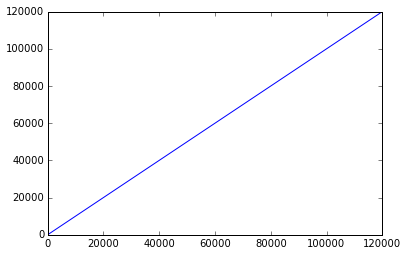

In [38]:
print vox_idx.shape
plt.plot(vox_idx)

In [40]:
# crcns_voxel_data.close()

#### get training/validation views on voxel_data

In [41]:
T = Tval+Ttrn
nvox= V
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]


In [42]:
ms.receptive_fields.G

1014

### Step 5: run that shit.

#### initialize the feature weights

In [43]:
initial_feature_weights = 'zeros'
print nvox

119218


#### train the model!

In [ ]:
fvl,ffw,frf,beh = train_fwrf_model(trn_mst,
                 trn_voxel_data,
                 initial_feature_weights = initial_feature_weights,
                 voxel_binsize = 16000,
                 rf_grid_binsize=10,
                 learning_rate=10**(-7.0),
                 max_iters = 300,
                 early_stop_fraction=0.2,
                 report_every = 100)

--------------voxels from 0 to 19869
--------candiate rf models 0 to 10
-------
errors: 2.602402
change in best rf: 80123.000000
norm of feature weights: 0.007041
improvements: 198690
0.668741941452
-------
errors: 2.583717
change in best rf: 3.000000
norm of feature weights: 0.701347
improvements: 87985
47.1146440506
-------
errors: 2.567673
change in best rf: 6.000000
norm of feature weights: 1.377134
improvements: 82168
46.2558858395
--------candiate rf models 10 to 20
-------
errors: 2.602398
change in best rf: 92964.000000
norm of feature weights: 0.007068
improvements: 198690
0.65438914299
-------
errors: 2.583457
change in best rf: -10.000000
norm of feature weights: 0.703661
improvements: 87442
47.9440169334
-------
errors: 2.567309
change in best rf: 7.000000
norm of feature weights: 1.380937
improvements: 81350
47.6992681026
--------candiate rf models 20 to 30
-------
errors: 2.602411
change in best rf: 98486.000000
norm of feature weights: 0.007088
improvements: 198690
0.667

In [21]:
max(frf)

1013

#### loss histories, all voxels

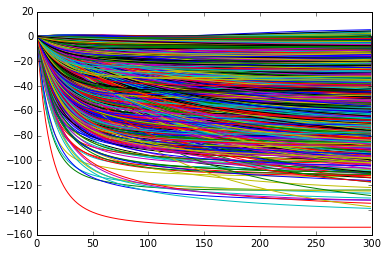

In [22]:
_=plt.plot(beh-beh[0,:])


#### view loss history for a few voxels

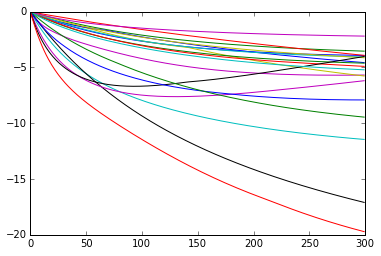

In [168]:
_=plt.plot(beh[:,slice(0,-1,1200)]-beh[0,slice(0,-1,1200)])

In [24]:
##loss in "final_validation_loss" = last point of "best_error_history"
print np.min(beh[:,-2])
print fvl[-2]

363.263977051
363.263977051


#### diff between first and last point of loss history, all voxels

In [25]:
np.sum(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)))

195428.75225830078

(0, 140)

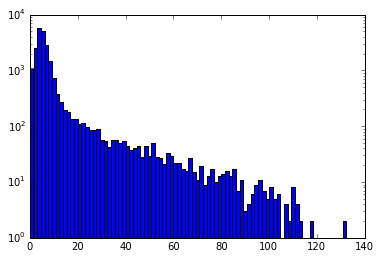

In [26]:
_=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
plt.yscale('log')
plt.xlim([0, 140])

### Step 6: model analysis and validation

#### histogram of rf models selected for each voxel

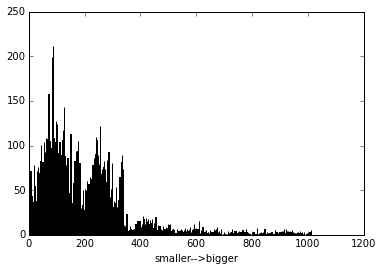

In [27]:
_=plt.hist(frf,ms.receptive_fields.G)
plt.xlabel('smaller-->bigger')

#### sum of all selected rfs. 

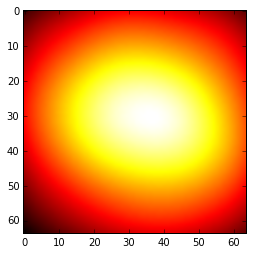

In [28]:
plt.imshow(np.sum(ms.receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy for all voxels

In [29]:
##grab validation data
val_voxel_data = voxel_data[valIdx,0:nvox]

In [30]:
##generate predictions
# pred = prediction_menu(val_mst, ffw[np.newaxis,:,:], rf_indices = frf) ##<<too big, choked. 


##generate predictions one voxel at a time
pred = np.zeros((Tval,nvox))
for v in range(nvox):  ##FIXED ! ?<<some kind of bug in training function, last voxel getting skipped...th
    pred[:,v] = np.squeeze(bigmult(val_mst[np.newaxis,frf[v],:,:],
                                   ffw[np.newaxis,:,v, np.newaxis]))

In [31]:
##get correlation = prediction accuracy
val_cc = []  
for v in range(nvox): 
    cc = pearsonr(val_voxel_data[:,v],pred[:,v])
    if not np.isnan(cc[0]):
        val_cc.append(cc[0])

(-0.4, 0.9)

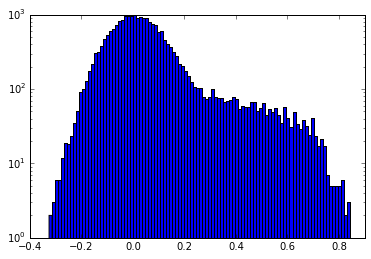

In [39]:
##histogram of prediction accuracy, all voxels
_=plt.hist(val_cc,100)
plt.yscale('log')
plt.ylim([10**0, 10**3])
plt.xlim([-.4, 0.9])

In [49]:
np.sum(map(lambda x: x > 0.2, val_cc))

2973

#### area-wise prediction accuracy

In [33]:
##get position information. need to re-open file
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')

vox_position = crcns_voxel_data['voxIdxS1'][0,no_nan]  ##index into a 64 x 64 x 18 volume (matlab-style raveling)

##get the indices for visual areas
roi_indicator = crcns_voxel_data['roiS1'][0, no_nan]
roi_names = ['other', 'v1', 'v2', 'v3', 'v3A', 'v3B', 'v4', 'LO']

crcns_voxel_data.close()

In [34]:
##area-wise prediction accuracy
areawise_accuracy = []
for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    areawise_accuracy.append(np.array(val_cc)[voxels_in_roi])

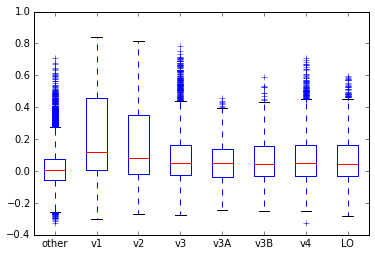

In [35]:
_=plt.boxplot(areawise_accuracy,labels = roi_names)

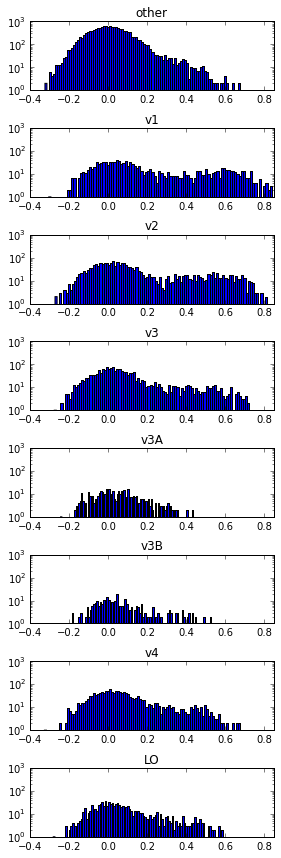

In [36]:
n_rois = len(roi_names)
fig = plt.figure(figsize = (4,12))
for ii,roi in enumerate(roi_names):
    plt.subplot(n_rois,1,ii+1)
    plt.hist(areawise_accuracy[ii],100)
    plt.yscale('log')
    plt.xlim([-0.4, 0.85])
    plt.ylim([0, 10**3])
    plt.title(roi)
plt.tight_layout()  

#### area-wise rf size vs. eccentricity

In [40]:
## construct data table of rfs--indices will now be voxels
frf_sizes = ms.receptive_fields.rf_table.loc[frf,'deg_per_radius'].values
frf_eccentricities = ms.receptive_fields.rf_table.loc[frf, ['x_deg','y_deg']].apply(lambda row: np.sqrt(row['x_deg']**2+row['y_deg']**2),axis=1).values
named_voxels = [roi_names[int(v)] for v in roi_indicator]

In [41]:
model_table = pd.DataFrame(data=list(frf_sizes), columns=['roi_size'])
model_table['eccentricity'] = frf_eccentricities
model_table['area'] = named_voxels
model_table['valcc'] = val_cc

model_table

,roi_size,eccentricity,area,valcc
0,0.75,7.071068,other,0.016621
1,0.75,7.071068,other,0.056791
2,0.75,9.718253,other,0.016221
3,2.20,6.871843,other,0.166364
4,2.20,0.000000,other,0.226424
5,2.20,6.009252,other,-0.091731
6,8.00,6.009252,other,0.054761
7,0.75,5.000000,other,0.162747
8,3.65,10.137938,other,0.165865
9,0.75,10.671874,other,-0.033040


In [42]:
val_thresh = 0.25
size_means = {}
size_stds = {}
area_eccs = {}
for roi in roi_names:
    area_stats = model_table.loc[(model_table['area']==roi) & (model_table['valcc'] > val_thresh),['roi_size', 'eccentricity']]
    ecc_grp = area_stats.groupby(by='eccentricity')
    size_means[roi] = []
    size_stds[roi] = []
    area_eccs[roi] = []
    for name,grp in ecc_grp:
        area_eccs[roi].append(name)
        size_means[roi].append(grp.roi_size.mean())
        size_stds[roi].append(grp.roi_size.std())
    

(0, 8)

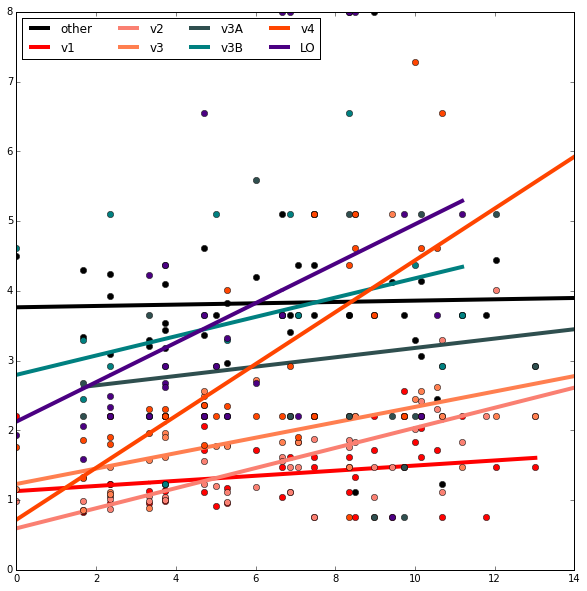

In [43]:
roi_colors = ['black', 'r', 'salmon', 'coral', 'darkslategray', 'teal','orangered', 'indigo' ]
ecc = np.sort(np.unique(model_table['eccentricity']))
line_list = []
fig = plt.figure(figsize=(10,10))
for r,roi in enumerate(roi_names):
    plt.plot(area_eccs[roi],size_means[roi], 'o', color=roi_colors[r])
    p = np.polyfit(area_eccs[roi],size_means[roi],1)
    l, = plt.plot(area_eccs[roi], np.polyval(p,area_eccs[roi]), color=roi_colors[r], label=roi, linewidth=4)
    line_list.append(l)
    
plt.legend(loc='upper left', ncol = 4)    
# plt.axis('equal')
plt.xlim([0,14])
plt.ylim([0,8])


#### layer x area weight distribution

/home/tnaselar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


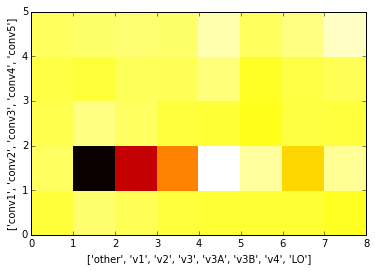

In [45]:
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
weights = np.zeros(( len(ms.feature_depth.keys()), len(roi_names),))

for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    layer_cnt = 0
    for layer in layer_names:
        idx = ms.feature_indices[layer]
        weights[layer_cnt,ii] = np.mean(ffw[idx,:][:,voxels_in_roi])
        layer_cnt += 1

plt.pcolor(weights, cmap='hot')
plt.ylabel(layer_names)
plt.xlabel(roi_names)
        

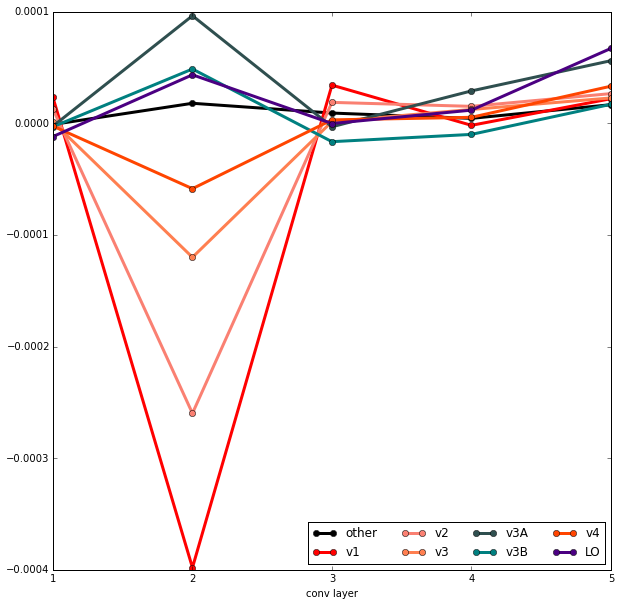

In [46]:
plt.figure(figsize = (10,10))
for ii,roi in enumerate(roi_names):
    _=plt.plot([1,2,3,4,5],weights[:,ii],'o-',label=roi, color = roi_colors[ii], linewidth=3)
plt.legend(loc='lower right', ncol=4)
plt.xticks([1,2,3,4,5])
plt.xlabel('conv layer')


### Step 7: Save objects

In [47]:
import pickle
saving_place = '/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/'
saving_file = 'model_space_'+version_number+'.p'
ms.optimal_feature_weights = ffw
ms.optimal_rf_model = frf
ms.vox_idx = vox_idx
ms.vox_position = vox_position
pickle.dump(ms, open( join(saving_place, saving_file), "wb"))


### Step 8: Convert models to weight maps and save

#### first test the weight maps and bias arrays to make sure they give correct predictions

In [58]:
##much smaller
deepnet_val_feature_dict = loadmat('/media/tnaselar/Data/deepnet_vim-1/vim-1_val_response.mat')
##it contains some key/value pairs we don't want
deepnet_val_feature_dict = {key: value.astype('float32') for key, value in deepnet_val_feature_dict.items() if key not in junk_keys}
print deepnet_val_feature_dict.keys()

['conv3', 'conv2', 'conv1', 'conv5', 'conv4']


In [159]:
num_test_vox = 10
new_test_pred = np.zeros((val_mst.shape[1],num_test_vox))
for layer in ms.feature_depth.keys():
    pix_per_stim = ms.feature_resolutions[layer]
    rf_stack = ms.receptive_fields.make_rf_stack(pix_per_stim,min_pix_per_radius=ms.min_pix_per_radius)
    feature_idx = ms.feature_indices[layer]
    for v in range(num_test_vox):
        wts = rf_stack[frf[v], np.newaxis,:,:]*ffw[feature_idx, v, np.newaxis,np.newaxis]  ##
        feat_part = wts/ms.normalization_constant[1][frf[v],0,feature_idx,np.newaxis,np.newaxis]
        feat_part = np.nan_to_num(feat_part)
        bias = ms.normalization_constant[0][frf[v],0,feature_idx]/ms.normalization_constant[1][frf[v],0,feature_idx]
        bias = np.nan_to_num(bias)
        bias = bias.dot(ffw[feature_idx, v])        
        new_test_pred[:, v] += np.sum((feat_part[np.newaxis,:,:,:]*deepnet_val_feature_dict[layer]), axis = (1,2,3))
        new_test_pred[:, v] -= bias


at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)


In [166]:
feat_part.shape

(384, 13, 13)

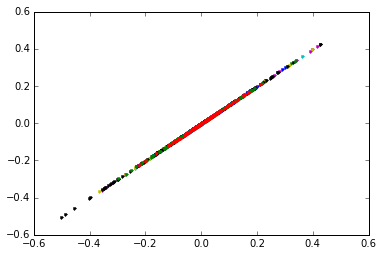

In [165]:
_=plt.plot(new_test_pred, pred[:,0:num_test_vox], '.')

#### calculate and package.
construct layerwise weight maps and bias arrays. for each layer we write an hdf5 dataset with the following fields:

weight_map  ~ V x D x S x S  

bias_array  ~ V

and then, for convenience, each layer gets a redundant copy of:

val_cc      ~ V 

val_idx     ~ V



In [180]:
for layer in ms.feature_depth.keys():
    print '----writing feature maps for %s layer' %(layer)
    f = h5py.File(join(saving_place, layer+'.hdf5'), "w")
    pix_per_stim = ms.feature_resolutions[layer]
    weight_map = f.create_dataset(layer+'_weight_map', shape=(V,ms.feature_depth[layer],pix_per_stim, pix_per_stim),dtype='float32')
    bias_array = f.create_dataset(layer+'_bias', shape = (V,), dtype='float32')
    rf_stack = ms.receptive_fields.make_rf_stack(pix_per_stim,min_pix_per_radius=ms.min_pix_per_radius)
    feature_idx = ms.feature_indices[layer]
    for v in range(V):
        
        ##multiply the feature weights element-wise across space
        tmp_wts = rf_stack[frf[v], np.newaxis,:,:]*ffw[feature_idx, v, np.newaxis,np.newaxis]

        ##divide out the stdev of each feature across space, convert nans to 0's
        feat_part = tmp_wts/ms.normalization_constant[1][frf[v],0,feature_idx,np.newaxis,np.newaxis]
        feat_part = np.nan_to_num(feat_part)

        ##construct additive bias term to subtract after application of feature weights to feature maps (in each layer)
        bias = ms.normalization_constant[0][frf[v],0,feature_idx]/ms.normalization_constant[1][frf[v],0,feature_idx]
        bias = np.nan_to_num(bias)
        bias = bias.dot(ffw[feature_idx, v])        
        
        weight_map[v, :, :, :] = feat_part
        bias_array[v] = bias
        if not np.mod(v,100):
            print 'wrote %d out of %d weights for layer %s' %(v, len(vox_idx), layer)
    
    ##add a copy of the validation scores and voxel indices to each layer file
    f.create_dataset(layer+'_validation_cc', shape = (V,), dtype='float32', data = val_cc)
    f.create_dataset(layer+'_voxel_indices', shape = (V,), dtype='float32', data = vox_idx)
    
    f.close()

----writing feature maps for conv3 layer
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
wrote 0 out of 22701 weights for layer conv3
wrote 100 out of 22701 weights for layer conv3
wrote 200 out of 22701 weights for layer conv3
wrote 300 out of 22701 weights for layer conv3
wrote 400 out of 22701 weights for layer conv3
wrote 500 out of 22701 weights for layer conv3
wrote 600 out of 22701 weights for layer conv3
wrote 700 out of 22701 weights for layer conv3
wrote 800 out of 22701 weights for layer conv3
wrote 900 out of 22701 weights for layer conv3
wrote 1000 out of 22701 weights for layer conv3
wrote 1100 out of 22701 weights for layer conv3
wrote 1200 out of 22701 weights for layer conv3
wrote 1300 out of 22701 weights for layer conv3
wrote 1400 out of 22701 weights for layer conv3
wrote 1500 out of 22701 weights for layer conv3
wrote 1600 out of 22701 weights for layer conv3
wrote 1700 out of 22701 weights for layer conv3
wrote 1800 out of 22701 weigh

### Step 9: Save in "native" format

In [3]:
import pickle
import h5py
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
V = 22701 ##known

version_number =  '0p2'
saving_place = '/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/'
saving_file = 'model_space_'+version_number+'.p'
ms = pickle.load(open(join(saving_place, saving_file), 'r'))

Using gpu device 0: GeForce GTX TITAN X


In [5]:
ms.normalization_constant[1].shape

(1014, 1, 1376)

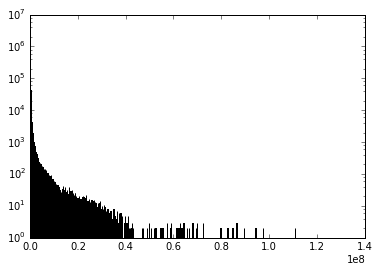

In [13]:
_=plt.hist(ms.normalization_constant[1].ravel(),1000,log=True)

plt.yscale('log')
plt.xscale('log')
# plt.xlim([10**-8, 10**8])

In [14]:
np.sum(map(lambda x: x < 10**-10, ms.normalization_constant[1].ravel()))

173114

In [25]:
ffw = ms.optimal_feature_weights
frf = ms.optimal_rf_model

for layer in ms.feature_depth.keys():
    print '----writing feature maps for %s layer' %(layer)
    f = h5py.File(join(saving_place, layer+'_seperable.hdf5'), "w")
    pix_per_stim = ms.feature_resolutions[layer]
    weight_matrix = f.create_dataset(layer+'_weight_matrix', shape=(ms.feature_depth[layer],V),dtype='float32')
    rf_params = f.create_dataset(layer + '_rf_params', shape = (3,V), dtype='float32')
    mu_array = f.create_dataset(layer + '_mu', shape = (ms.feature_depth[layer],V), dtype='float32')
    lambda_array = f.create_dataset(layer + '_lambda', shape = (ms.feature_depth[layer],V), dtype='float32')
    
    feature_idx = ms.feature_indices[layer]
    for v in range(V):
        
#         weight_matrix[:,v] = ffw[feature_idx, v] / ms.normalization_constant[1][frf[v],0,feature_idx].T
#         weight_matrix[:,v] = np.nan_to_num(weight_matrix[:,v])

        weight_matrix[:,v] = ffw[feature_idx, v] 
    
        lambda_array[:,v] = ms.normalization_constant[1][frf[v],0,feature_idx].T
        
        mu_array[:,v] = ms.normalization_constant[0][frf[v],0,feature_idx].T
        
        rf_params[:,v] = ms.receptive_fields.rf_table.loc[frf[v]].values
        
#         bias = ms.normalization_constant[0][frf[v],0,feature_idx]/ms.normalization_constant[1][frf[v],0,feature_idx]
#         bias = np.nan_to_num(bias)
#         bias = bias.dot(ffw[feature_idx, v])       
#         bias_array[v] = bias
        if not np.mod(v,100):
            print 'wrote %d out of %d weights for layer %s' %(v, len(ms.vox_idx), layer)
 
    
    ##add a copy of the validation scores and voxel indices to each layer file
#     f.create_dataset(layer+'_validation_cc', shape = (V,), dtype='float32', data = val_cc)
    f.create_dataset(layer+'_voxel_indices', shape = (V,), dtype='float32', data = ms.vox_idx)
    
    f.close()

----writing feature maps for conv3 layer
wrote 0 out of 22701 weights for layer conv3
wrote 100 out of 22701 weights for layer conv3
wrote 200 out of 22701 weights for layer conv3
wrote 300 out of 22701 weights for layer conv3
wrote 400 out of 22701 weights for layer conv3
wrote 500 out of 22701 weights for layer conv3
wrote 600 out of 22701 weights for layer conv3
wrote 700 out of 22701 weights for layer conv3
wrote 800 out of 22701 weights for layer conv3
wrote 900 out of 22701 weights for layer conv3
wrote 1000 out of 22701 weights for layer conv3
wrote 1100 out of 22701 weights for layer conv3
wrote 1200 out of 22701 weights for layer conv3
wrote 1300 out of 22701 weights for layer conv3
wrote 1400 out of 22701 weights for layer conv3
wrote 1500 out of 22701 weights for layer conv3
wrote 1600 out of 22701 weights for layer conv3
wrote 1700 out of 22701 weights for layer conv3
wrote 1800 out of 22701 weights for layer conv3
wrote 1900 out of 22701 weights for layer conv3
wrote 2000 

In [189]:
foo = np.zeros((3, 2))
foo[:,0] = ms.receptive_fields.rf_table.loc[0].values

In [190]:
foo[:,0]

array([  0.75, -10.  , -10.  ])

In [ ]:
ms.